In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import tensorflow as tf
import numpy as np

IMAGES_WITH = 128
IMAGES_HEIGHT = 128

images_path = "/content/drive/MyDrive/Data/Water Bodies Dataset/Images"
masks_path = "/content/drive/MyDrive/Data/Water Bodies Dataset/Masks"

images = []
masks = []
for path in os.listdir(images_path):
  image = tf.io.read_file(images_path + "/" + path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, (IMAGES_HEIGHT, IMAGES_WITH), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  image = tf.math.divide(image, 255)
  images.append(image)

  mask = tf.io.read_file(masks_path + "/" + path)
  mask = tf.image.decode_jpeg(mask, channels=1)
  mask = tf.image.resize(mask, (IMAGES_HEIGHT, IMAGES_WITH), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  mask = tf.where(mask > 127, 1, 0)
  masks.append(mask)

images = np.array(images)
masks = np.array(masks)

print(images.shape)
print(masks.shape)

split = 0.8

images_train = images[:int(images.shape[0]*split)]
images_val = images[int(images.shape[0]*split):]

print(images_train.shape)
print(images_val.shape)

masks_train = masks[:int(masks.shape[0]*split)]
masks_val = masks[int(masks.shape[0]*split):]

print(masks_train.shape)
print(masks_val.shape)

(2841, 128, 128, 3)
(2841, 128, 128, 1)
(2272, 128, 128, 3)
(569, 128, 128, 3)
(2272, 128, 128, 1)
(569, 128, 128, 1)


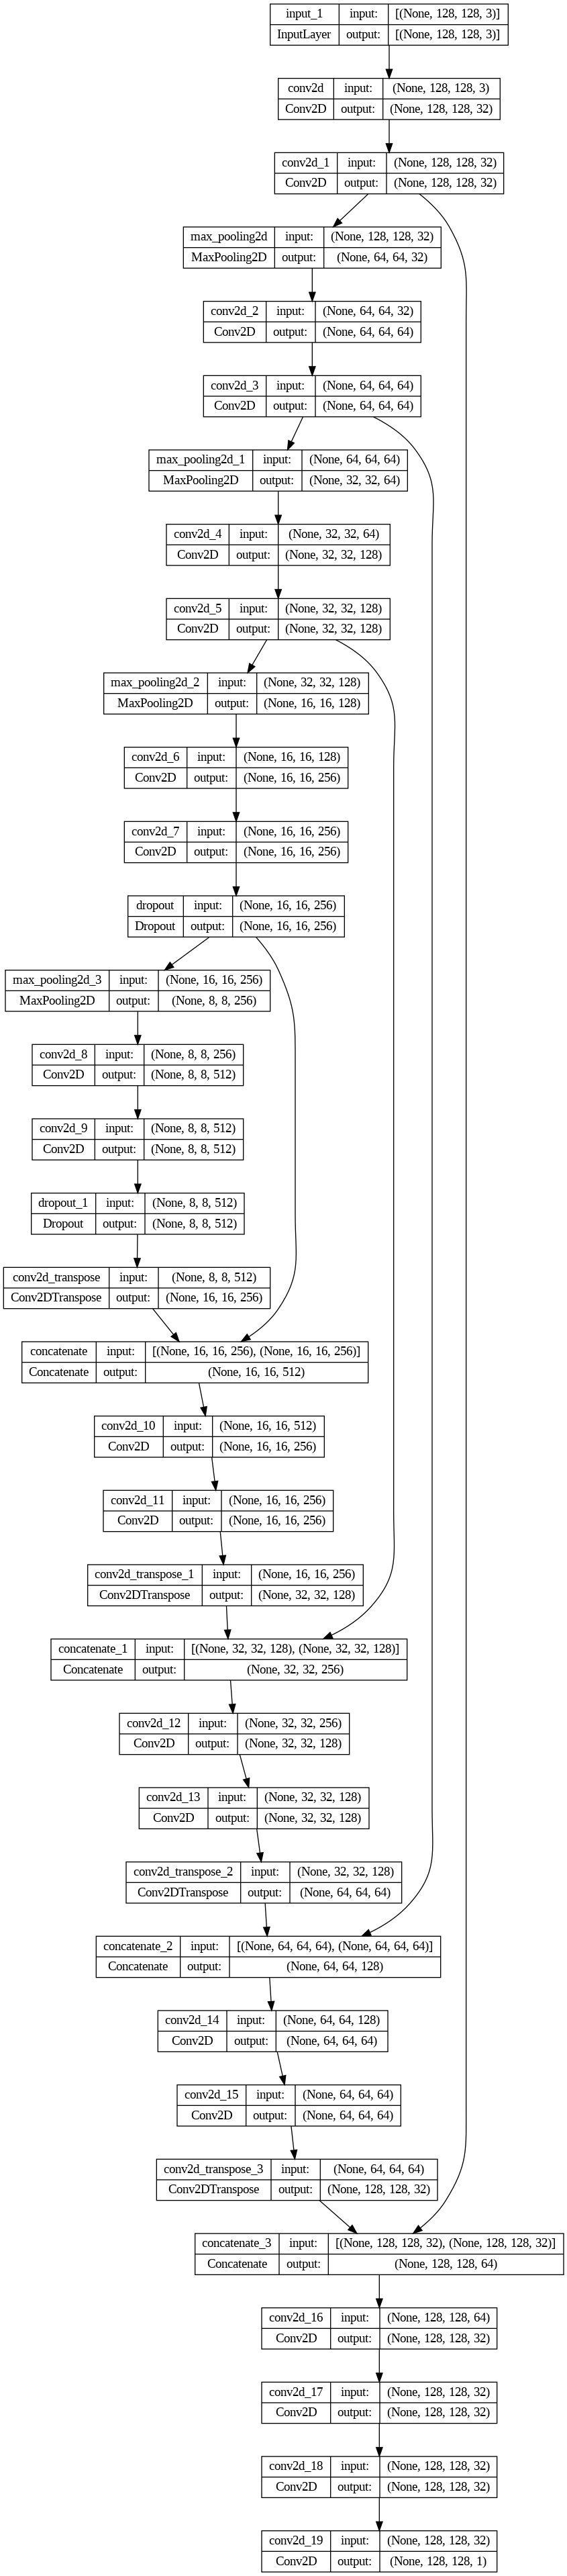

In [2]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

    conv = tf.keras.layers.Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)

    conv = tf.keras.layers.Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv)
    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

def upsampling_block(expansive_input, contractive_input, n_filters=32):

    up = tf.keras.layers.Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)

    merge = tf.keras.layers.concatenate([up, contractive_input], axis=3)

    conv = tf.keras.layers.Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)

    conv = tf.keras.layers.Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)

    return conv

def unet_model(input_size=(128, 128, 3), n_filters=32):

    inputs = tf.keras.layers.Input(input_size)

    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], 2*n_filters)
    cblock3 = conv_block(cblock2[0], 2**2*n_filters)
    cblock4 = conv_block(cblock3[0], 2**3*n_filters, dropout_prob=0.3)
    cblock5 = conv_block(cblock4[0], 2**4*n_filters, dropout_prob=0.3, max_pooling=False)

    ublock6 = upsampling_block(cblock5[0], cblock4[1],  2**3*n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  2**2*n_filters)
    ublock8 = upsampling_block(ublock7, cblock2[1],  2*n_filters)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = tf.keras.layers.Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = tf.keras.layers.Conv2D(1, 1, padding='same',activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

model = unet_model(input_size=(IMAGES_HEIGHT, IMAGES_WITH, 3), n_filters=32)

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

In [28]:
history = model.fit(images_train, masks_train, epochs=10, validation_data=(images_val, masks_val))

Epoch 1/10
71/71 [==============================] - 15s 215ms/step - loss: 0.4908 - accuracy: 0.7999 - val_loss: 0.4666 - val_accuracy: 0.8150
Epoch 2/10
71/71 [==============================] - 15s 214ms/step - loss: 0.4270 - accuracy: 0.8160 - val_loss: 0.4454 - val_accuracy: 0.8190
Epoch 3/10
71/71 [==============================] - 16s 219ms/step - loss: 0.4292 - accuracy: 0.8194 - val_loss: 0.4173 - val_accuracy: 0.8257
Epoch 4/10
71/71 [==============================] - 16s 221ms/step - loss: 0.3912 - accuracy: 0.8384 - val_loss: 0.3889 - val_accuracy: 0.8373
Epoch 5/10
71/71 [==============================] - 16s 219ms/step - loss: 0.3760 - accuracy: 0.8459 - val_loss: 0.3851 - val_accuracy: 0.8390
Epoch 6/10
71/71 [==============================] - 16s 223ms/step - loss: 0.3559 - accuracy: 0.8578 - val_loss: 0.3758 - val_accuracy: 0.8405
Epoch 7/10
71/71 [==============================] - 16s 228ms/step - loss: 0.3658 - accuracy: 0.8551 - val_loss: 0.3665 - val_accuracy: 0.8508

1/1 [==============================] - 0s 22ms/step


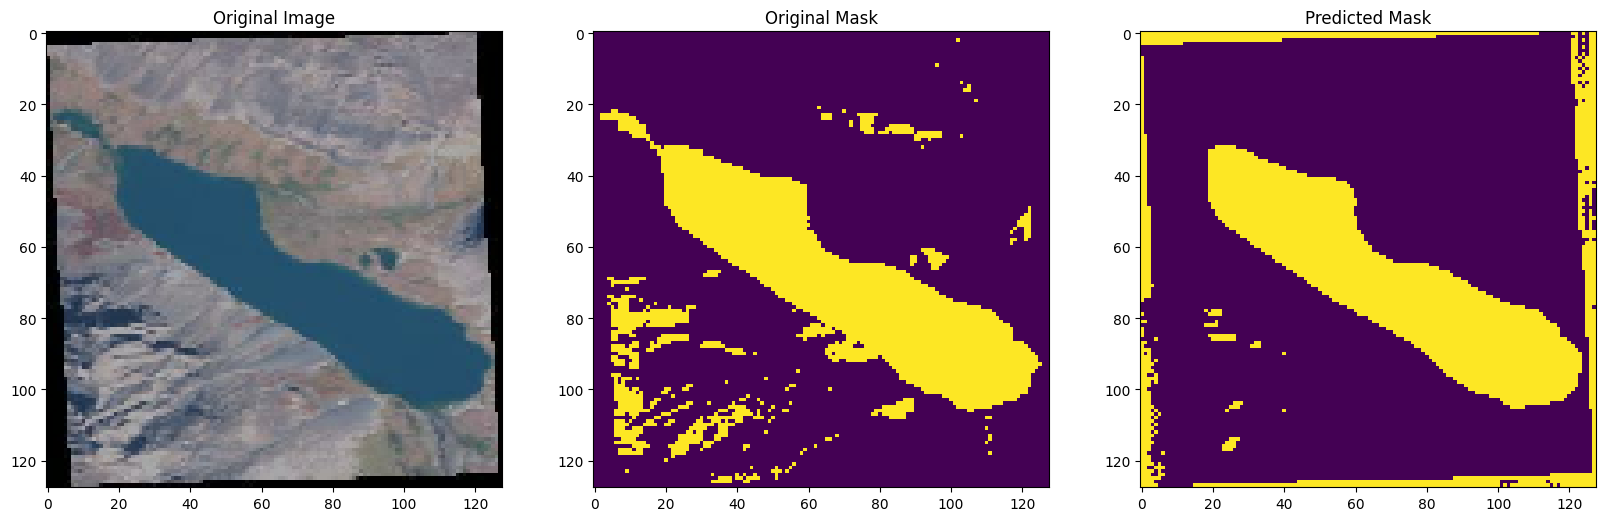

In [37]:
import random
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 3, figsize=(20,20))

rand_num = random.randint(0, images_val.shape[0])

original_img = images_val[rand_num]
axes[0].imshow(original_img)
axes[0].title.set_text('Original Image')

original_mask = masks_val[rand_num]
axes[1].imshow(original_mask)
axes[1].title.set_text('Original Mask')

predicted_mask = model.predict(np.array([original_img]))[0]
predicted_mask = tf.where(predicted_mask > 0.5, 1, 0)
axes[2].imshow(predicted_mask)
axes[2].title.set_text('Predicted Mask')